In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
#Evrişimli Sinir Ağı Kütüphaneler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [6]:
veri=pd.read_csv("egitim.csv")
#28*28 piksel düzleştirilmiş ve 784 sutün olarak veriye eklenmiştir. 
#1 tane de sınıf/label bilgisi var toplamda 785 sütun vardır
print(f"Verinin boyutu: {veri.shape}") 
veri.head()

Verinin boyutu: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#Labellerı ayıralım
Y_veri=veri["label"]
#x eğitim veri setini oluşturalım 
X_veri=veri.drop(["label"], axis=1)
print("X veri:", X_veri.shape)
print("Y veri:", Y_veri.shape)

X veri: (42000, 784)
Y veri: (42000,)


In [8]:
print("Sınıflar ve örnek sayıları: ",Y_veri.value_counts())

Sınıflar ve örnek sayıları:  label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64


In [9]:
#Resmin boyutunu kullanacağız
resim_boyutu=int(np.sqrt(X_veri.shape[1]))
resim_boyutu

28

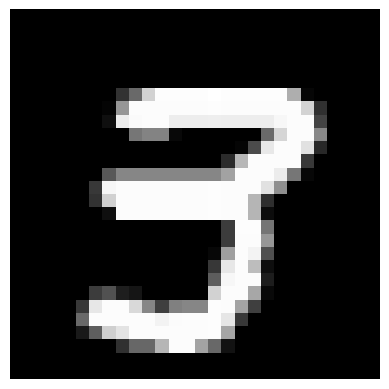

In [10]:
#verimizi görselleştirelim 3 sınıfı
resim1=X_veri.iloc[2000].values
resim1=resim1.reshape((resim_boyutu, resim_boyutu))
plt.imshow(resim1, cmap="gray")
plt.axis("off")
plt.show()

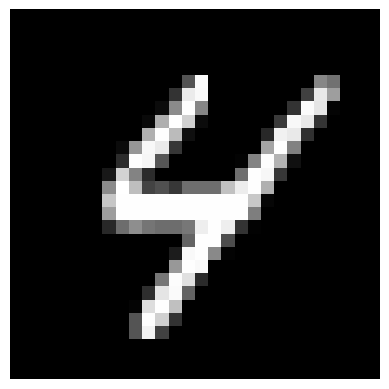

In [11]:
#verimizi görselleştirelim 4 sınıfı
resim2=X_veri.iloc[19000].values
resim2=resim2.reshape((resim_boyutu, resim_boyutu))
plt.imshow(resim2, cmap="gray")
plt.axis("off")
plt.show()

In [12]:
#normalize the data
#Aydınlatmanın farklılıklarının etkisini azaltmak için gri tonlamalı normalleştirme yapıyoruz.
X_veri =X_veri /255.0

In [13]:
#Reshape
#Tüm verileri 28x28x1 3B matrislere yeniden şekillendiriyoruz. 
#Çünkü Keras girdi olarak 3B veri kabul ediyor.
#Keras'ın sonunda kanallara karşılık gelen ekstra bir boyuta ihtiyacı vardır.
#Görsellerimiz gri ölçeklidir, bu nedenle yalnızca bir kanal kullanır.
X_veri= X_veri.values.reshape(-1,28,28,1)
print(f"X eğitim boyut: {X_veri.shape}")

X eğitim boyut: (42000, 28, 28, 1)


In [14]:
#Etiketleri tek vektör olarak kodluyoruz
from tensorflow.keras.utils import to_categorical
Y_veri= to_categorical(Y_veri, num_classes=10)

In [15]:
#Split the train and the validation set for the fitting
from sklearn.model_selection import train_test_split
X_egitim, X_test, Y_egitim, Y_test= train_test_split(X_veri, Y_veri, test_size=0.1, random_state=2)
print(f"X Eğitim boyu {X_egitim.shape}")
print(f"X Test boyu {X_test.shape}")
print(f"Y Eğitim boyu {Y_egitim.shape}")
print(f"Y Test boyu {Y_test.shape}")

X Eğitim boyu (37800, 28, 28, 1)
X Test boyu (4200, 28, 28, 1)
Y Eğitim boyu (37800, 10)
Y Test boyu (4200, 10)


In [16]:
#Evrişim katmanından sonra aktivasyon fonksiyonu olarak ReLU kullanıyoruz. 
#Bu aktivasyonu fonksiyonu doğrusallığı kırarak, modelimizin doğrusal olmayan yapıları öğrenmesine olanak sağlıyor.
#conv => max pool => dropout => conv => max pool => dropout => fully connected (2 layer)
#Dropout: Seyreltme, rastgele seçilen nöronların eğitim sırasında göz ardı edildiği bir tekniktir. 
#Ezberlemeyi(over-fitting) önler.

from sklearn.metrics import confusion_matrix #bir karışıklık matrisi oluşturmak için 
import itertools
from keras.utils import to_categorical #etiketleri kategorik olarak kodlamak için
from keras.models import Sequential #sıralı bir model oluşturmak için
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D #modelin katmanlarını tanımlamak
from keras.optimizers import RMSprop, Adam #optimizasyon algoritmaları, modelin eğitimini düzenlemek
from tensorflow.keras.preprocessing.image import ImageDataGenerator #görüntü veri artırımı için
from keras.callbacks import ReduceLROnPlateau #öğrenme hızını azaltmak için

model= Sequential()
#1
model.add(Conv2D(filters=8, kernel_size= (5,5), padding= 'Same', 
                 activation= 'relu', input_shape= (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#2
model.add(Conv2D(filters=16, kernel_size= (3,3), padding= 'Same', 
                 activation= 'relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
#tam bağlantı
model.add(Flatten()) #özellik haritasını düzleştirir
model.add(Dense(256, activation= "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation= "softmax"))

In [17]:
#Adam optimizasyon yöntemi
# Birinci moment tahmini için kullanılan exponential decay hızını belirler. 
#Bu parametre, geçmiş gradyanların ne kadar etkili olacağını belirler. 
#İkinci moment tahmini için kullanılan exponential decay hızını belirler. 
#Bu parametre, geçmiş gradyanların karesinin ne kadar etkili olacağını belirler. 
optimizer= Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [18]:
#Kategorik çapraz entropi maliyet yöntemi
model.compile(optimizer= optimizer,
             loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
epochs= 10 #modelin eğitim veri seti üzerinde bir kez tamamen geçmesidir
batch_size= 250 #bir eğitim adımında kullanılan örnek sayısını belirtir

In [20]:
# Ezberleme sorununu önlemek için, 
#el yazısı rakam veri setimizi yapay olarak genişletmemiz gerekiyor.
datagen= ImageDataGenerator(
    featurewise_center=False, #girdi ortamalasını veri kümesi üzerinden 0 olarak ayarlayın
    samplewise_center=False, # her bir örnek ortalamasını 0 olarak ayarlayın
    featurewise_std_normalization=False, #girdileri veri kümesinin standartlarına böl
    samplewise_std_normalization=False,  # her girdiyi std'ye böl
    zca_whitening=False,  # dimesion reduction
    rotation_range=5,  # boyut küçültme
    zoom_range = 0.1, # % 10 görüntüyü rastgele yakınlaştır
    width_shift_range=0.1,  # görüntüleri yatay olarak rastgele kaydır % 10
    height_shift_range=0.1,  # görüntüleri dikey olarak rastgele kaydır % 10
    horizontal_flip=False,  # görüntüleri yatay olarak rastgele çevir
    vertical_flip=False)  # görüntüleri yadikeytay olarak rastgele çevir

datagen.fit(X_egitim)

In [21]:
#Modelin Eğitilmesi
history= model.fit(datagen.flow(X_egitim, Y_egitim, #Veri artırma işlemi gerçekleştirme ve eğitim veri setini döngüye sokma
                                         batch_size=batch_size),
                             epochs=epochs,
                             validation_data= (X_test, Y_test),
                            #her bir epoch boyunca modelin kaç tane veri topluluğu (batch) ile eğitileceğini belirtir.
                             steps_per_epoch=X_egitim.shape[0] // batch_size,
                           #2, her epoch sonunda ayrıntılı bilgi sağlar
                             verbose=2
                            )

Epoch 1/10
151/151 - 23s - 150ms/step - accuracy: 0.6453 - loss: 1.0601 - val_accuracy: 0.9498 - val_loss: 0.2025
Epoch 2/10
151/151 - 1s - 4ms/step - accuracy: 0.8280 - loss: 0.2894 - val_accuracy: 0.9488 - val_loss: 0.2026
Epoch 3/10
151/151 - 18s - 119ms/step - accuracy: 0.8728 - loss: 0.4040 - val_accuracy: 0.9624 - val_loss: 0.1312
Epoch 4/10
151/151 - 0s - 3ms/step - accuracy: 0.9040 - loss: 0.1786 - val_accuracy: 0.9629 - val_loss: 0.1309
Epoch 5/10
151/151 - 19s - 127ms/step - accuracy: 0.9042 - loss: 0.3049 - val_accuracy: 0.9693 - val_loss: 0.1077
Epoch 6/10
151/151 - 0s - 3ms/step - accuracy: 0.9320 - loss: 0.1231 - val_accuracy: 0.9698 - val_loss: 0.1077
Epoch 7/10
151/151 - 18s - 119ms/step - accuracy: 0.9177 - loss: 0.2629 - val_accuracy: 0.9724 - val_loss: 0.0938
Epoch 8/10
151/151 - 1s - 4ms/step - accuracy: 0.9240 - loss: 0.1548 - val_accuracy: 0.9719 - val_loss: 0.0952
Epoch 9/10
151/151 - 18s - 119ms/step - accuracy: 0.9277 - loss: 0.2325 - val_accuracy: 0.9748 - val

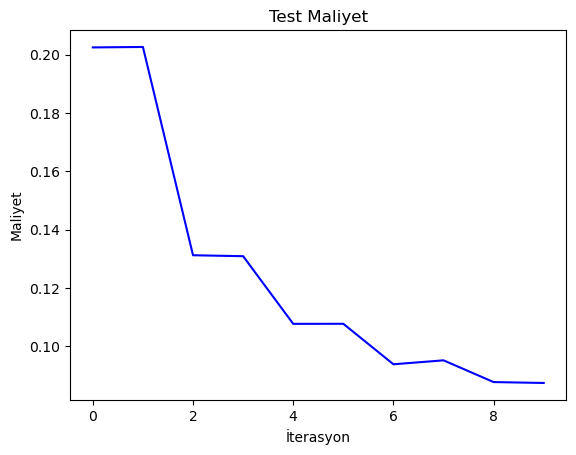

In [24]:
#Maliyet Görselleştirme
plt.plot(history.history['val_loss'], color='b')
plt.title("Test Maliyet")
plt.xlabel("İterasyon")
plt.ylabel("Maliyet")
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


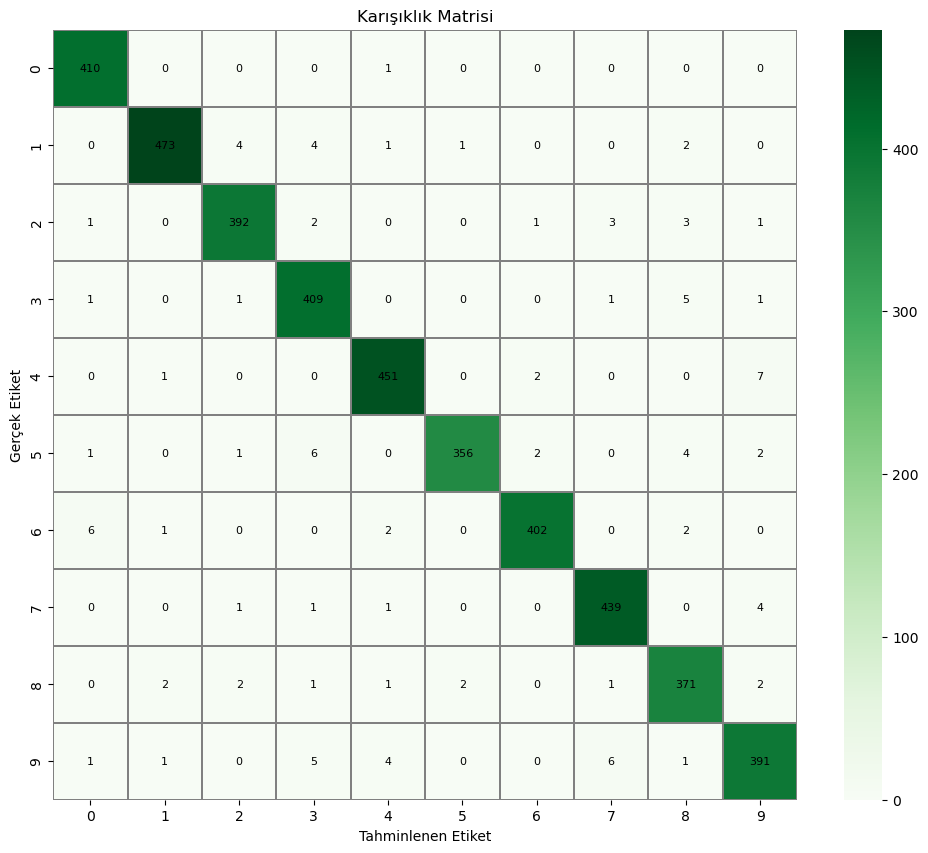

In [38]:
#veri test setinden sınıf tahmin et
Y_pred= model.predict(X_test)

#tahmin edilen veriyi çevir
#argmax dağılımlardan en yüksek olasılığa sahip sınıf indekslerini alır
Y_pred_classes= np.argmax(Y_pred,axis=1)

#test verisini çevir
Y_true= np.argmax(Y_test,axis=1)

#karışıklık matrisini hesapla
confusion_mtx=confusion_matrix(Y_true, Y_pred_classes)

#karışıklık matrisini çizdir
f, ax=plt.subplots(figsize=(12,10))
sns.heatmap(confusion_mtx, annot=False, linewidths=0.01,
           cmap="Greens", linecolor="gray", fmt='.1f', ax=ax)
# her hücrenin değerinin yazılması annot parametresi ile sağlanamayınca döngü ile yazıldı
for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        plt.text(j+0.5, i+0.5, confusion_mtx[i, j], ha='center', va='center', fontsize=8)
        
plt.xlabel("Tahminlenen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Karışıklık Matrisi")
plt.show()